<a href="https://colab.research.google.com/github/zakkaizzatur/Data-Related-Projects/blob/main/SMS_Spam_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SMS Spam Classification Project**

---

## Konteks
Permasalahan spam pada media pengiriman informasi merupakan masalah yang sering kita jumpai dalam kehidupan sehari-hari. Hal ini cukup mengganggu jika kita terus menerus mendapatkan pesan yang tidak kita butuhkan dalam jumlah yang banyak.

Sepertinya akan sangat membantu jika ada teknologi yang dapat menyaring pesan yang masuk kedalam *device* kita dan membuang atau menandai terlebih dahulu pesan spam yang kita dapatkan.

Untungnya, *machine learning* dapat menjawab tantangan ini. Dengan mempelajari berbagai jenis pesan yang tergolong dalam kategori spam atau bukan, kita dapat mengklasifikasikan jenis pesan yang kita dapatkan. Aplikasi nyata yang mungkin pernah kita lihat adalah penggunaannya pada penyedia layanan email yang dapat menyaring email dan memasukannya kedalam kategori-kategori tertentu. 

---

## Dataset
Pada *notebook* ini, dataset yang digunakan berasal dari Kaggle yang dapat diakses pada link berikut: [dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

Dataset ini berisi 5574 SMS dalam bahasa Inggris yang telah diberi label "spam" untuk pesan spam dan label "ham" untuk pesan bukan spam.

---
##Proses Klasifikasi

Proses klasifikasi yang akan dilakukan termasuk dalam Natural Language Processing(NLP). Langkah-langkah yang dilakukan pada project ini adalah sebagai berikut:


1.   Eksplorasi dan pembersihan data
2.   Tokenisasi & Padding kalimat
3.   Pembuatan model DNN dengan menambahkan layer embedding dan LSTM
4.   Pelatihan model
5.   Pengecekan akurasi&loss model 
6.   Pengetesan model








### Eksplorasi dan pembersihan data

In [ ]:
#import library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
link = '/content/spam.csv'

In [ ]:
df = pd.read_csv(link, encoding='latin') #membuka file csv

In [ ]:
df.head() #cek 5 baris pertama pada file

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Dapat terlihat bahwa terdapat 3 kolom yang berisi NaN, maka harus dilakukan *data cleaning* dengan membuang 3 kolom tersebut

In [ ]:
df.drop(columns=df.iloc[:,2:], inplace=True) #membuang kolom ketiga sampai kelima

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Nama kolom yang terdapat pada dataframe kurang mudah dimengerti, maka diganti menjadi 'spam' dan 'sentence'

In [ ]:
df.rename(columns={'v1':'spam','v2':'sentence'}, inplace=True)

Eksplorasi data dengan menggunakan barplot untuk mengetahui jumlah banyaknya pesan pada tiap kategori

([<matplotlib.axis.XTick at 0x7f16e3d7c690>,
 [Text(0, 0, 'spam'), Text(0, 0, 'ham')])

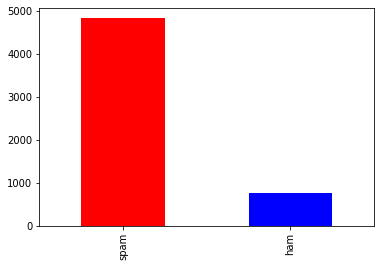

In [ ]:
df.spam.value_counts().plot(kind='bar', color=['red','blue'])
positions = (0,1)
labels = ("spam", "ham")
plt.xticks(positions, labels)

Dapat dilihat bahwa pesan dalam kategori spam jauh lebih banyak daripada ham, hampir 5x lipatnya. Walaupun perbedaan antar kategori yang besar dapat menyebabkan kemungkinan *bias* pada hasil prediksi, tetapi data ini tetap dapat digunakan karena kedua kategori dapat memberikan pembendaharaan kata yang lebih besar, jika dibandingkan dengan menyeimbangkan data untuk kedua kategori.

In [ ]:
df.spam = df.spam.apply({'ham':0,'spam':1}.get) #melakukan encoding untuk kedua kategori

In [ ]:
sentence = df.sentence.values #mengambil data tiap pesan
label = df.spam.values #mengambil data label (0/1)

### Tokenisasi & Padding kalimat

Import library-library yang relevan

In [ ]:
from sklearn.model_selection import train_test_split
sentence_latih, sentence_test, label_latih, label_test = train_test_split(sentence, label, test_size=0.2) #melakukan pembagian dataset untuk digunakan sebagai pelatihan dan test

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Menentukan hyperparameter yang akan digunakan pada proses tokenisasi kalimat
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_token = "x" 
vocab_size = 5000

In [ ]:
# Membuat objek tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

In [ ]:
# Tokenisasi pada kalimat pelatihan dan test
tokenizer.fit_on_texts(sentence_latih)
tokenizer.fit_on_texts(sentence_test)

# Mengubah kalimat ke dalam nilai sesuai dengan hasil tokenisasi
sekuens_latih = tokenizer.texts_to_sequences(sentence_latih)
sekuens_test = tokenizer.texts_to_sequences(sentence_test)

# Memberikan padding agar panjang sequence untuk tiap kalimat sama.
padded_latih = pad_sequences(sekuens_latih,maxlen=max_len,padding=padding_type,truncating=trunc_type)
padded_test = pad_sequences(sekuens_test,maxlen=max_len,padding=padding_type,truncating=trunc_type)

### Pembuatan model DNN dengan menambahkan layer embedding dan LSTM

In [ ]:
# Menentukan hyperparameter yang digunakan dalam pembuatan model DNN
embeding_dim = 16
drop_value = 0.5 # dropout

In [ ]:
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

model=Sequential()
model.add(Embedding(vocab_size,embeding_dim,input_length=max_len))
model.add(LSTM(64))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(64, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
#Daftar layer pada DNN
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 16)            80000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)               

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Pelatihan Model DNN

Pada pelatihan model DNN, digunakan fitur *callback* *early stopping* untuk menghentikan pelatihan model saat sudah mencapai tren loss tertentu.

In [ ]:
#Pelatihan DNN 
num_epochs = 30 #Banyaknya pelatihan
earlystop = EarlyStopping(monitor='val_loss', patience=3) #Setting fitur early stopping untuk callback, nilai patience dipilih sebagai batas nilai epoch dimana sebuah pelatihan tidak memberikan peningkatan performa apapun
history = model.fit(padded_latih, label_latih, epochs=num_epochs, validation_data=(padded_test, label_test), callbacks =[earlystop], verbose=2)

Epoch 1/30
140/140 - 7s - loss: 0.3186 - accuracy: 0.8941 - val_loss: 0.1595 - val_accuracy: 0.9722
Epoch 2/30
140/140 - 4s - loss: 0.0783 - accuracy: 0.9829 - val_loss: 0.0465 - val_accuracy: 0.9883
Epoch 3/30
140/140 - 4s - loss: 0.0295 - accuracy: 0.9915 - val_loss: 0.0443 - val_accuracy: 0.9892
Epoch 4/30
140/140 - 4s - loss: 0.0336 - accuracy: 0.9906 - val_loss: 0.0694 - val_accuracy: 0.9758
Epoch 5/30
140/140 - 4s - loss: 0.0310 - accuracy: 0.9921 - val_loss: 0.0507 - val_accuracy: 0.9910
Epoch 6/30
140/140 - 4s - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0730 - val_accuracy: 0.9865


Pelatihan DNN berhenti pada epoch ke 6 dengan akurasi validasi sebesar 98.65%

### Pengecekan akurasi&loss model

In [ ]:
model.evaluate(padded_test,label_test) #evaluasi model terhadap data testing

35/35 [==============================] - 0s 8ms/step - loss: 0.0730 - accuracy: 0.9865


[0.07299749553203583, 0.9865471124649048]

Menggambar plot loss dan accuracy untuk melihat perkembangan model pada tiap epoch

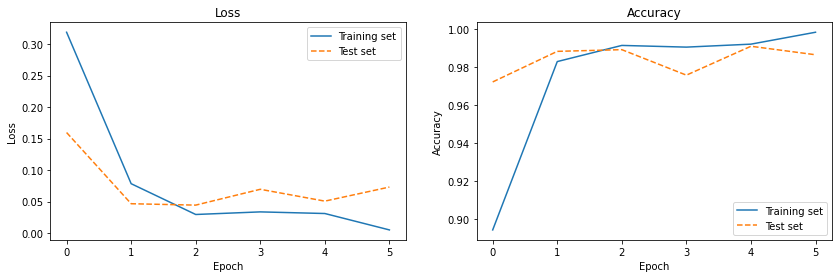

In [ ]:
hist=history
loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()

plt.show()

### Pengetesan model

In [ ]:
# Membuat fungsi untuk mengecek pesan tertentu
def cekpesan(sentence):
  sekuenspesan=tokenizer.texts_to_sequences([sentence])
  padded=pad_sequences(sekuenspesan,maxlen=max_len,padding=padding_type,truncating=trunc_type)
  prediksi=(model.predict(padded))
  labelpesan="ham"
  skor=prediksi[0][0]
  if skor >= 0.3:
    labelpesan="spam"
  prediksi=[skor,labelpesan]
  return (prediksi)

In [ ]:
# Cek pesan non-spam
pred_text = "Spam is an unsolicited email message that is automatically sent to a large number of addresses at once"

cekpesan(pred_text)

[0.00034192204, 'ham']

In [ ]:
# Cek pesan spam
pred_text = "sale today! to stop texts call 98912460324"

cekpesan(pred_text)

[0.9999708, 'spam']